In [2]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from moviepy.editor import *
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Input, RepeatVector, Dropout
from keras.models import Model
from keras.optimizers import Nadam, Adam
from keras.layers import LSTM, GRU
from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout

2024-09-09 17:23:46.945980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 17:23:46.959167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 17:23:46.963191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 17:23:46.972456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 17:23:47.561233: W tensorflow/compiler/tf2

In [3]:
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model

In [4]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
data_dir =  "Gun_NoGun_Dataset_augmented/"
IMAGE_HEIGHT, IMAGE_WIDTH= 224,224

SEQUENCE_LENGTH =30

In [6]:
class_categories_list = ["Gun", "NoGun"]
model_output_length = len(class_categories_list)

In [7]:
max_pixel_value = 255
def extract_frame(video_path):
  # frames_list = []

  # #print(" the video file path is : {}".format(video_path))
  # videoObj = cv2.VideoCapture(video_path)
  # #print("the video object is: {}".format(videoObj))

  # """ Iterating through Video Frames """
  # while True:

  #   # Reading a frame from the video file
  #   success, image = videoObj.read()
  #   #print("the value of success is: {}".format(success))

  #   if not success:
  #     break

  #   resized_frame = cv2.resize(image, (image_height, image_width))

  #   """Normalize the resized frame by dividing it with 255 so that 
  #   each pixel value then lies between 0 and 1"""

  #   normalized_frame = resized_frame / max_pixel_value
  #   frames_list.append(normalized_frame)

    
  # videoObj.release()


    frames_list = []
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
    
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
    
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
    
        if not success:
            break
    
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    
    video_reader.release()


    return frames_list



In [8]:
def data_creation():

    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(class_categories_list):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(data_dir, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(data_dir, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = extract_frame(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [9]:
features, labels = data_creation()

Extracting Data of Class: Gun
Extracting Data of Class: NoGun


In [10]:
print("the shape of the feature = {}".format(features.shape))
print("the shape of the labels = {}".format(labels.shape))

the shape of the feature = (516, 30, 224, 224, 3)
the shape of the labels = (516,)


In [11]:
one_hot_encoded_labels = to_categorical(labels)

In [12]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, 
                                                                            test_size = 0.2, 
                                                                            shuffle = True, 
                                                                            random_state = 0)

In [13]:
print("the shape of the feature = {}".format(features_train.shape))
print("the shape of the labels = {}".format(labels_train.shape))

the shape of the feature = (412, 30, 224, 224, 3)
the shape of the labels = (412, 2)


In [14]:
print("the shape of the feature = {}".format(features_test.shape))
print("the shape of the labels = {}".format(labels_test.shape))

the shape of the feature = (104, 30, 224, 224, 3)
the shape of the labels = (104, 2)


In [15]:
from tensorflow.keras.models import load_model

no_of_channels = 3

# Load the saved model
mobileNet_model = load_model('MobileNet_Date_Time_2024_08_17__15_45_52___Loss_0.05901234969496727___Accuracy_0.9815759658813477.h5')


# Define the input shape
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, no_of_channels)

# Remove the classification head (last layer)
mobileNet_model = Model(inputs=mobileNet_model.inputs, outputs=mobileNet_model.layers[-5].output)

# Set the new input shape
#mobileNet_model.build(input_shape)

# Print the updated model summary
mobileNet_model.summary()

I0000 00:00:1725917166.031782 2444530 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725917166.035332 2444530 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725917166.113959 2444530 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725917166.116772 2444530 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
mobileNet_input = Input(shape=(SEQUENCE_LENGTH,
                           IMAGE_HEIGHT,
                            IMAGE_WIDTH,
                            no_of_channels))

In [17]:
video_frames_encoded = TimeDistributed(mobileNet_model)(mobileNet_input)

In [18]:
video_frames_encoded

<KerasTensor shape=(None, 30, 1280), dtype=float32, sparse=False, name=keras_tensor_329>

In [19]:
no_of_classes = 2

In [20]:
video_frames_encoded_sequence = GRU(256)(video_frames_encoded)
#video_frames_encoded_sequence = Dropout(0.5)(video_frames_encoded_sequence)

hidden_layer1 = Dense(1024, activation="relu")(video_frames_encoded_sequence)
#hidden_layer1 = Dropout(0.5)(hidden_layer1)

hidden_layer2 = Dense(512, activation="relu")(hidden_layer1)
#hidden_layer2 = Dropout(0.5)(hidden_layer2)

hidden_layer3 = Dense(256, activation="relu")(hidden_layer2)
#hidden_layer3 = Dropout(0.25)(hidden_layer3)

hidden_layer4 =  Dense(128, activation="relu")(hidden_layer3)
#hidden_layer4 = Dropout(0.25)(hidden_layer4)

hidden_layer5 =  Dense(64, activation="relu")(hidden_layer4)
#hidden_layer5 = Dropout(0.25)(hidden_layer5)

outputs = Dense(no_of_classes, activation="softmax")(hidden_layer5)
model = Model([mobileNet_input], outputs)

In [21]:
optimizer = Adam(learning_rate=0.00001)
                  # beta_1=0.9,
                  # beta_2=0.999,
                  # epsilon=1e-08,
                  # weight_decay=0.004)

In [22]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]) 

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 256)            │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,399,746 (16.78 MB)

 Trainable params: 2,141,762 (8.17 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor="val_loss",
                      mode="min",
                      restore_best_weights=True,
                      patience=5)
checkpoint = ModelCheckpoint('MobileNet+GRU_best_weights.keras',
                             monitor='val_accuracy',
                            #  monitor='val_f1_score',
                             verbose=1,
                             mode='max',
                             save_best_only=True)
callbacks = [early_stopping_callback, checkpoint]

In [25]:
features_train.shape, labels_train.shape

((412, 30, 224, 224, 3), (412, 2))

In [26]:
# Start Training
model_training_history = model.fit(x = features_train, 
                                   y = labels_train, 
                                   epochs = 100, 
                                   batch_size = 16,
                                   shuffle = True, 
                                   callbacks=[callbacks],
                                   validation_split = 0.2)

Epoch 1/100


2024-09-09 17:27:08.138685: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1725917228.228615 2462404 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917228.245344 2462404 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917228.245805 2462404 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917228.246290 2462404 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917228.246758 2462404 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917228.251301 2462404 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917228.252281 2462404 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917228.253497 2462404 gpu_t

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5845 - loss: 0.6755

W0000 00:00:1725917233.563106 2462402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917233.563582 2462402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917233.563975 2462402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917233.564387 2462402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917233.564783 2462402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917233.565245 2462402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917233.565670 2462402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917233.566078 2462402 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917233.566503 2462402 gp


Epoch 1: val_accuracy improved from -inf to 0.49398, saving model to MobileNet+GRU_best_weights.keras


W0000 00:00:1725917251.772415 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917251.772777 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917251.773078 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917251.773455 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917251.773768 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917251.774078 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917251.774409 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917251.774728 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917251.775050 2462403 gp

21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5835 - loss: 0.6755 - val_accuracy: 0.4940 - val_loss: 0.6822
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5889 - loss: 0.6453
Epoch 2: val_accuracy improved from 0.49398 to 0.55422, saving model to MobileNet+GRU_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.5886 - loss: 0.6453 - val_accuracy: 0.5542 - val_loss: 0.6607
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6944 - loss: 0.6226
Epoch 3: val_accuracy improved from 0.55422 to 0.63855, saving model to MobileNet+GRU_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.6942 - loss: 0.6226 - val_accuracy: 0.6386 - val_loss: 0.6410
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7342 - loss: 0.6014
Epoch 4: val_accuracy improved from 0.63855 to 0.68675, saving model to MobileNet+GRU_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.7338 - loss: 0.6013 

In [27]:
features_test.shape

(104, 30, 224, 224, 3)

In [28]:
# import datetime as dt

# model2_evaluation_history = model.evaluate(features_test, labels_test)

# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()

# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
# model_evaluation_loss, model_evaluation_accuracy = model2_evaluation_history
# model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
# # Saving your Model
# model.save(model_name)


In [29]:
labels_pred_prob = model.predict(features_test)

W0000 00:00:1725917941.471804 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917941.472369 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917941.472885 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917941.473481 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917941.474079 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917941.474694 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917941.475310 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917941.476044 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917941.476793 2462403 gp

4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step 


W0000 00:00:1725917958.940447 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.940886 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.941261 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.941662 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.942062 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.942459 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.942889 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.943284 2462403 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725917958.943708 2462403 gp

In [30]:
labels_pred_prob

array([[9.99934316e-01, 6.57153942e-05],
       [1.67454958e-01, 8.32545042e-01],
       [9.98918056e-01, 1.08201627e-03],
       [9.54357034e-04, 9.99045670e-01],
       [7.85829558e-04, 9.99214172e-01],
       [1.08828896e-03, 9.98911738e-01],
       [9.99758184e-01, 2.41876740e-04],
       [9.67037141e-01, 3.29629220e-02],
       [7.61480696e-05, 9.99923825e-01],
       [4.51889366e-01, 5.48110664e-01],
       [9.99847770e-01, 1.52162815e-04],
       [1.03226164e-03, 9.98967767e-01],
       [2.90143682e-04, 9.99709785e-01],
       [7.34606510e-05, 9.99926567e-01],
       [9.99920607e-01, 7.94248044e-05],
       [9.99200404e-01, 7.99563422e-04],
       [8.33416265e-03, 9.91665781e-01],
       [9.13913682e-05, 9.99908566e-01],
       [3.51041468e-04, 9.99648929e-01],
       [9.99448597e-01, 5.51439880e-04],
       [9.89897609e-01, 1.01024499e-02],
       [8.92747223e-01, 1.07252769e-01],
       [6.51728944e-04, 9.99348223e-01],
       [1.21522637e-04, 9.99878407e-01],
       [8.773887

In [32]:
labels_pred = np.argmax(labels_pred_prob, axis = 1)
labels_test = np.argmax(labels_test, axis = 1)
labels_pred, labels_test

(array([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]),
 array([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]))

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, labels_pred)
print(cm)

[[54  0]
 [ 0 50]]


In [34]:
from sklearn.metrics import classification_report
report = classification_report(labels_test, labels_pred)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        50

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104



In [35]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [36]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels_test, labels_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
auc_score = roc_auc_score(labels_test, labels_pred_prob[:, 1])
print(auc_score)

1.0


In [37]:
fpr, tpr, thresholds

(array([0., 0., 0., 1.]),
 array([0.  , 0.02, 1.  , 1.  ]),
 array([          inf, 9.9997818e-01, 5.4811066e-01, 3.4763532e-05],
       dtype=float32))

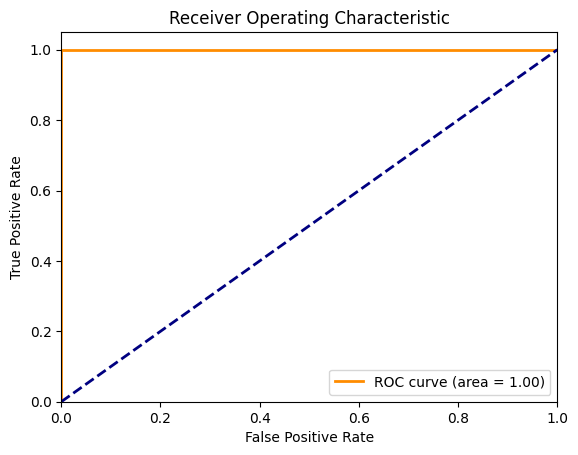

In [38]:
# Plot ROC curve
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metric(measure_name_1, measure_name_2, plot_title):
  
 
  measure_value_1 = model_training_history.history[measure_name_1]
  measure_value_2 = model_training_history.history[measure_name_2] 
  epochs = range(len(measure_value_1))

  plt.plot(epochs, measure_value_1, 'blue', label = measure_name_1)
  plt.plot(epochs, measure_value_2, 'red', label = measure_name_2)   

  plt.title(str(plot_title))
  plt.legend()
  plt.show()


In [ ]:
plot_metric('loss', 'val_loss', 'Total Training Loss vs Total Validation Loss')

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')